# SEA-POL low-level gridded rain rate

Level 4v1.1

/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.1/PICCOLO_level4_rainrate_2D.nc

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cmweather
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

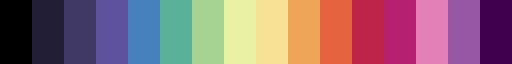

In [2]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='gray') #set missing (NaN) values to gray

discrete_mask_cmap

In [3]:
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.1/PICCOLO_level4_rainrate_2D.nc')
seapol

<xarray.Dataset> Size: 47GB
Dimensions:          (time: 8158, Y: 491, X: 491)
Coordinates:
  * X                (X) float32 2kB -2.45e+05 -2.44e+05 ... 2.44e+05 2.45e+05
  * Y                (Y) float32 2kB -2.45e+05 -2.44e+05 ... 2.44e+05 2.45e+05
    latitude         (time, Y, X) float32 8GB ...
    longitude        (time, Y, X) float32 8GB ...
  * time             (time) datetime64[ns] 65kB 2024-08-16T08:10:00 ... 2024-...
Data variables:
    DBZ              (time, Y, X) float32 8GB ...
    HID              (time, Y, X) float32 8GB ...
    RAINRATE         (time, Y, X) float32 8GB ...
    elevation_angle  (time, Y, X) float32 8GB ...
    grid_mapping     int32 4B ...
    heading          (time) float32 33kB ...
    start_time       (time) datetime64[ns] 65kB ...
    stop_time        (time) datetime64[ns] 65kB ...
Attributes: (12/15)
    Conventions:       CF-1.12
    institution:       Colorado State University
    source:            CSU SEA-POL radar
    instrument:        SEA-POL
    title:             Level 4 Gridded SEA-POL Radar Data
    summary:           Level 4 Gridded SEA-POL Radar Data
    ...                ...
    project:           PICCOLO, BOWTIE, ORCESTRA
    platform:          RV METEOR
    keywords:          radar, precipitation, sea-pol
    processing_level:  Level 4
    license:           CC-BY-4.0
    history:           v1.1 with azimuth correction

In [ ]:
# Mask out missing data (-32769 = no data possible)
rainrate = seapol.RAINRATE.where(seapol.RAINRATE >=-30000, np.nan)
dbz = seapol.DBZ.where(seapol.DBZ >=-30000, np.nan)

In [5]:
# Change -9999 missing data to zeros (data possible but removed = "not raining" though technically could be below beam) 
rainrate2 = rainrate.where(rainrate != -9999., 0)
#dbz2 = dbz
dbz2 = dbz.where(rainrate != -9999., np.nan)

In [6]:
# Also mask out seemingly bad data (rainrate > 10000 mm/h) or > 1000 mm/h --> set to zero (like saying there is no echo)
rainrate3 = rainrate2.where((rainrate2 <= 10000) | (rainrate2.isnull()), 0) # keep nans
dbz3 = dbz2.where((rainrate2 <= 10000) | (dbz2.isnull()), np.nan)
rainrate4 = rainrate3.where((rainrate3 <= 1000) | (rainrate3.isnull()), 0)
dbz4 = dbz3.where((rainrate3 <= 1000) | (dbz3.isnull()), np.nan)

# or donn't
#rainrate4 = rainrate2
#dbz4 = dbz2

In [16]:
#Check for bad data

ihigh = np.where(rainrate2 > 1000)
ihigh

(array([  14,   14,   15,   23,   25,   30,   31,   38,   38, 1479, 2719,
        2741, 2744, 2744, 2744, 2744, 2744, 2744, 2744, 2754, 2769, 2769,
        2769, 2769, 2769, 2769, 2769, 2769, 2770, 2770, 2770, 2770, 2774,
        2774, 2774, 2774, 2778, 2778, 2778, 2780, 2780, 2785, 2787, 2787,
        2787, 2787, 2787]),
 array([265, 266, 266, 277, 270, 301, 288, 311, 314, 223, 344, 301, 292,
        292, 293, 294, 295, 296, 298, 289, 261, 262, 262, 263, 263, 264,
        267, 268, 261, 262, 263, 264, 284, 287, 288, 289, 254, 255, 255,
        251, 252, 255, 243, 244, 244, 245, 245]),
 array([248, 250, 249, 259, 267, 275, 281, 272, 266, 223, 126, 139, 139,
        140, 140, 140, 140, 140, 137, 141, 150, 150, 151, 150, 151, 151,
        147, 147, 151, 151, 151, 151, 230, 234, 234, 230, 154, 153, 154,
        154, 154, 151, 156, 155, 156, 155, 156]))

In [17]:
#Print out the bad data

for i in range(len(ihigh[0])):
    print(f"Rainrate: {rainrate2[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values} mm/h at time {seapol.time[ihigh[0][i]].values} and lat/lon {seapol.latitude[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values}, {seapol.longitude[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values}")



Rainrate: 1017.5282592773438 mm/h at time 2024-08-16T09:35:00.000000000 and lat/lon 16.827926635742188, -24.987722396850586
Rainrate: 1065.67529296875 mm/h at time 2024-08-16T09:35:00.000000000 and lat/lon 16.836957931518555, -24.96895408630371
Rainrate: 1019.9017944335938 mm/h at time 2024-08-16T09:40:00.000000000 and lat/lon 16.82700538635254, -24.973705291748047
Rainrate: 1108.142578125 mm/h at time 2024-08-16T10:20:00.000000000 and lat/lon 16.82131004333496, -24.831132888793945
Rainrate: 1204.8546142578125 mm/h at time 2024-08-16T10:30:00.000000000 and lat/lon 16.731388092041016, -24.74381446838379
Rainrate: 1074.124267578125 mm/h at time 2024-08-16T21:30:00.000000000 and lat/lon 15.276019096374512, -23.89130973815918
Rainrate: 1014.4528198242188 mm/h at time 2024-08-16T21:35:00.000000000 and lat/lon 15.14163589477539, -23.829654693603516
Rainrate: 1000.3053588867188 mm/h at time 2024-08-16T22:20:00.000000000 and lat/lon 15.229962348937988, -23.870027542114258
Rainrate: 1124.989746

# Take spatial averages

I need to fix this to nan out rain245 when it is on the 5s (no LONG)

In [ ]:
#Spatial mean over 245 km x 245 km
rain245 = rainrate4.mean(dim=('X','Y'),skipna=True)

#Spatial mean over 120 km x 120 km
rain120 = rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).mean(dim=('X','Y'),skipna=True)

#Spatial mean over 60 km x 60 km
rain60 = rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).mean(dim=('X','Y'),skipna=True)

#Spatial mean over 12 km x 12 km
rain12 = rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).mean(dim=('X','Y'),skipna=True)

#Spatial mean within 1 km
rain1 = rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).mean(dim=('X','Y'),skipna=True)


In [90]:
rain245[400:420]

<xarray.DataArray 'RAINRATE' (time: 20)> Size: 80B
array([0.0143106 , 0.05650231, 0.17496036, 0.08136544, 0.23792025,
       0.07560992, 0.08559519, 0.11181989, 0.06085223, 0.01298586,
       0.01368152, 0.03839353, 0.14822869, 0.08086244, 0.0315622 ,
       0.0722921 , 0.05548842, 0.07596901, 0.07362684, 0.06120794],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 160B 2024-08-18T08:30:00 ... 2024-08-18T10...

In [47]:
# Find indices of known bad data times (to mask out)
# Search times
time1a= np.datetime64('2024-08-16T00:00:00') #CV islands
time1b = np.datetime64('2024-08-17T02:00:00') #CV islands
time2a = np.datetime64('2024-08-27T22:00:00') #Praia
time2b = np.datetime64('2024-08-28T07:00:00') #Praia
time3 = np.datetime64('2024-09-21T18:10:00') #RCP shutdown bad data

#Find indices for start and end times
index1a = np.abs(pd.to_datetime(rain245.time) - time1a).argmin()
index1b = np.abs(pd.to_datetime(rain245.time) - time1b).argmin()
index2a = np.abs(pd.to_datetime(rain245.time) - time2a).argmin()
index2b = np.abs(pd.to_datetime(rain245.time) - time2b).argmin()
index3 = np.abs(pd.to_datetime(rain245.time) - time3).argmin()
print(f"Index for time 1a: {index1a}")
print(f"Index for time 1b: {index1b}")
print(f"Index for time 2a: {index2a}")
print(f"Index for time 2b: {index2b}")
print(f"Index for time 3: {index3}")


#Set bad data to NaN
rain245[index1a:index1b+1] = np.nan
rain245[index2a:index2b+1] = np.nan
rain245[index3] = np.nan
rain120[index1a:index1b+1] = np.nan
rain120[index2a:index2b+1] = np.nan
rain120[index3] = np.nan
rain60[index1a:index1b+1] = np.nan
rain60[index2a:index2b+1] = np.nan
rain60[index3] = np.nan
rain12[index1a:index1b+1] = np.nan
rain12[index2a:index2b+1] = np.nan
rain12[index3] = np.nan
rain1[index1a:index1b+1] = np.nan
rain1[index2a:index2b+1] = np.nan
rain1[index3] = np.nan

Index for time 1a: 0
Index for time 1b: 74
Index for time 2a: 2681
Index for time 2b: 2787
Index for time 3: 7823


In [87]:
rain245[400:410]

<xarray.DataArray 'RAINRATE' (time: 10)> Size: 40B
array([0.0143106 , 0.05650231, 0.17496036, 0.08136544, 0.23792025,
       0.07560992, 0.08559519, 0.11181989, 0.06085223, 0.01298586],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 80B 2024-08-18T08:30:00 ... 2024-08-18T09:...

In [48]:
# Conditional mean (only where rainrate > 0)
rain245cond = rainrate4.where(rainrate4>0).mean(dim=('X','Y'),skipna=True)
rain120cond = rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).where(rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000))>0).mean(dim=('X','Y'),skipna=True)
rain60cond = rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).where(rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000))>0).mean(dim=('X','Y'),skipna=True)
rain12cond = rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).where(rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000))>0).mean(dim=('X','Y'),skipna=True)
rain1cond = rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).where(rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000))>0).mean(dim=('X','Y'),skipna=True)

In [49]:
#set bad data to NaN
rain245cond[index1a:index1b+1] = np.nan
rain245cond[index2a:index2b+1] = np.nan
rain245cond[index3] = np.nan

rain120cond[index1a:index1b+1] = np.nan
rain120cond[index2a:index2b+1] = np.nan
rain120cond[index3] = np.nan

rain60cond[index1a:index1b+1] = np.nan
rain60cond[index2a:index2b+1] = np.nan
rain60cond[index3] = np.nan

rain12cond[index1a:index1b+1] = np.nan
rain12cond[index2a:index2b+1] = np.nan
rain12cond[index3] = np.nan

rain1cond[index1a:index1b+1] = np.nan
rain1cond[index2a:index2b+1] = np.nan
rain1cond[index3] = np.nan



# Calculate fractional area coverage of precip (>0)

In [50]:
# Find number of points with rainrate > 0
rain245count = rainrate4.where(rainrate4>0).count(dim=('X','Y'))
rain120count = rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).where(rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000))>0).count(dim=('X','Y'))
rain60count = rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).where(rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000))>0).count(dim=('X','Y'))
rain12count = rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).where(rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000))>0).count(dim=('X','Y'))
rain1count = rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).where(rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000))>0).count(dim=('X','Y'))  

# Calculate fractional area coverage of precip (>0)
rain245frac = rain245count / (rainrate4.X.size * rainrate4.Y.size)
rain120frac = rain120count / (rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).X.size * rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).Y.size)
rain60frac = rain60count / (rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).X.size * rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).Y.size)
rain12frac = rain12count / (rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).X.size * rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).Y.size)
rain1frac = rain1count / (rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).X.size * rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).Y.size)  

# Set bad data to NaN
rain245frac[index1a:index1b+1] = np.nan
rain120frac[index1a:index1b+1] = np.nan
rain60frac[index1a:index1b+1] = np.nan
rain12frac[index1a:index1b+1] = np.nan
rain1frac[index1a:index1b+1] = np.nan

rain245frac[index2a:index2b+1] = np.nan
rain120frac[index2a:index2b+1] = np.nan
rain60frac[index2a:index2b+1] = np.nan
rain12frac[index2a:index2b+1] = np.nan
rain1frac[index2a:index2b+1] = np.nan

rain245frac[index3] = np.nan
rain120frac[index3] = np.nan
rain60frac[index3] = np.nan
rain12frac[index3] = np.nan
rain1frac[index3] = np.nan

## Pad missing data with nans so it is on a regular 10-min time grid ... or a 5-min grid

In [ ]:
# Make regular 10-minute time series
start_time = np.datetime64('2024-08-16T08:00:00')
end_time = np.datetime64('2024-09-23T16:50:00')
time10m = pd.date_range(start_time, end_time, freq='10 min')
time10m = pd.to_datetime(time10m)

# Make placeholder data array of nans of len(time10m)
rain245mean = np.full(len(time10m), np.nan)
rain120mean = np.full(len(time10m), np.nan)
rain60mean = np.full(len(time10m), np.nan)
rain12mean = np.full(len(time10m), np.nan)
rain1mean = np.full(len(time10m), np.nan)

rain245int = np.full(len(time10m), np.nan)
rain120int = np.full(len(time10m), np.nan)
rain60int = np.full(len(time10m), np.nan)
rain12int = np.full(len(time10m), np.nan)
rain1int = np.full(len(time10m), np.nan)

rain245fa = np.full(len(time10m), np.nan)
rain120fa = np.full(len(time10m), np.nan)
rain60fa = np.full(len(time10m), np.nan)
rain12fa = np.full(len(time10m), np.nan)
rain1fa = np.full(len(time10m), np.nan)

# Convert both time arrays to pandas.DatetimeIndex for reliable comparison
seapol_times = pd.to_datetime(seapol.time.values)

# Find indices in time10m that are exactly in seapol.time
mask = np.isin(time10m, seapol_times)
matched_idx = np.where(mask)[0]

# Find corresponding indices in seapol.time for the matched times
seapol_idx = {t: i for i, t in enumerate(seapol_times)}
matched_seapol_idx = [seapol_idx[t] for t in time10m[mask]]

# Fill arrays only at matched indices
rain245mean[matched_idx]    = rain245.values[matched_seapol_idx]
rain120mean[matched_idx]    = rain120.values[matched_seapol_idx]
rain60mean[matched_idx]     = rain60.values[matched_seapol_idx]
rain12mean[matched_idx]     = rain12.values[matched_seapol_idx]
rain1mean[matched_idx]      = rain1.values[matched_seapol_idx]

rain245int[matched_idx] = rain245cond.values[matched_seapol_idx]
rain120int[matched_idx] = rain120cond.values[matched_seapol_idx]
rain60int[matched_idx]  = rain60cond.values[matched_seapol_idx]
rain12int[matched_idx]  = rain12cond.values[matched_seapol_idx]
rain1int[matched_idx]   = rain1cond.values[matched_seapol_idx]

rain245fa[matched_idx] = rain245frac.values[matched_seapol_idx]
rain120fa[matched_idx] = rain120frac.values[matched_seapol_idx]
rain60fa[matched_idx]  = rain60frac.values[matched_seapol_idx]
rain12fa[matched_idx]  = rain12frac.values[matched_seapol_idx]
rain1fa[matched_idx]   = rain1frac.values[matched_seapol_idx]

# Convert to xarray data arrays
rain245mean = xr.DataArray(rain245mean, coords=[time10m], dims=['time'], name='rainrate_245km_mean')
rain120mean = xr.DataArray(rain120mean, coords=[time10m], dims=['time'], name='rainrate_120km_mean')
rain60mean = xr.DataArray(rain60mean, coords=[time10m], dims=['time'], name='rainrate_60km_mean')
rain12mean = xr.DataArray(rain12mean, coords=[time10m], dims=['time'], name='rainrate_12km_mean')
rain1mean = xr.DataArray(rain1mean, coords=[time10m], dims=['time'], name='rainrate_1km_mean')

rain245int = xr.DataArray(rain245int, coords=[time10m], dims=['time'], name='rainrate_245km_int')
rain120int = xr.DataArray(rain120int, coords=[time10m], dims=['time'], name='rainrate_120km_int')
rain60int = xr.DataArray(rain60int, coords=[time10m], dims=['time'], name='rainrate_60km_int')
rain12int = xr.DataArray(rain12int, coords=[time10m], dims=['time'], name='rainrate_12km_int')
rain1int = xr.DataArray(rain1int, coords=[time10m], dims=['time'], name='rainrate_1km_int')

rain245fa = xr.DataArray(rain245fa, coords=[time10m], dims=['time'], name='rainrate_245km_frac')
rain120fa = xr.DataArray(rain120fa, coords=[time10m], dims=['time'], name='rainrate_120km_frac')
rain60fa = xr.DataArray(rain60fa, coords=[time10m], dims=['time'], name='rainrate_60km_frac')
rain12fa = xr.DataArray(rain12fa, coords=[time10m], dims=['time'], name='rainrate_12km_frac')
rain1fa = xr.DataArray(rain1fa, coords=[time10m], dims=['time'], name='rainrate_1km_frac')


# Write out spatial averages to file

In [ ]:
#combine into one dataset
#regular 10-min time array with nans where missing data
rainrate = xr.Dataset({'rain245_mean': rain245mean, 'rain120_mean': rain120mean, 'rain60_mean': rain60mean, 'rain12_mean': rain12mean, 'rain1_mean': rain1mean, 'rain245_int': rain245int, 'rain120_int': rain120int, 'rain60_int': rain60int, 'rain12_int': rain12int, 'rain1_int': rain1int,
                       'rain245_frac': rain245fa, 'rain120_frac': rain120fa, 'rain60_frac': rain60fa, 'rain12_frac': rain12fa, 'rain1_frac': rain1fa})

#native time array that is blnk where missing data
#rainrate = xr.Dataset({'rain245_mean': rain245, 'rain120_mean': rain120, 'rain60_mean': rain60, 'rain12_mean': rain12, 'rain1_mean': rain1, 'rain245_int': rain245cond, 'rain120_int': rain120cond, 'rain60_int': rain60cond, 'rain12_int': rain12cond, 'rain1_int': rain1cond})

#add attributes
rainrate.attrs['title'] = 'Spatial mean rainrate from SEA-POL long-range, low-elevation scans'
rainrate.attrs['description'] = ('Spatial means of rainrate from SEA-POL long-range, low-elevation scans at different spatial scales. '
                                 'Mean is the average over all valid data points (including zeros). '
                                 'Int (intensity) is the average over all data points where rainrate > 0.'
                                 'fa is the fractional area coverage of rainrate > 0.')
rainrate.attrs['source'] = 'SEA-POL Level4b Gridded 2D Rain Rate'
rainrate.attrs['units'] = 'mm/h'

#save to netcdf
rainrate.to_netcdf('/home/awing/orcestra/data/SEA-POL_4v1.0_rainrate_2D_spatial_means_masked_reg10.nc')

rainrate

<xarray.Dataset> Size: 1MB
Dimensions:       (time: 11051)
Coordinates:
  * time          (time) datetime64[ns] 88kB 2024-08-16T08:00:00 ... 2024-09-...
Data variables: (12/15)
    rain245_mean  (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    rain120_mean  (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    rain60_mean   (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    rain12_mean   (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    rain1_mean    (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    rain245_int   (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    ...            ...
    rain1_int     (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    rain245_frac  (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    rain120_frac  (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    rain60_frac   (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    rain12_frac   (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
    rain1_frac    (time) float64 88kB nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4b Gridded 2D Rain Rate
    units:        mm/h

In [29]:
# Set BP and AP times
BPtime = np.datetime64('2024-08-28T06:00:00')
APtime = np.datetime64('2024-08-28T20:00:00')

#Find indices for start and end times
indexBP = np.abs(pd.to_datetime(seapol.time) - BPtime).argmin()
indexAP = np.abs(pd.to_datetime(seapol.time) - APtime).argmin()

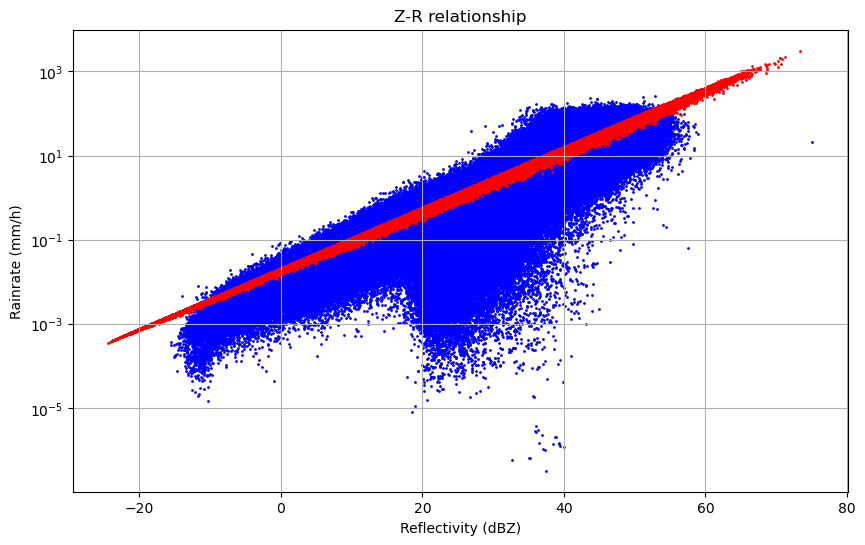

In [30]:
#scatter plot of dbz vs rainrate
plt.figure(figsize=(10,6))
plt.scatter(dbz2[indexAP:-1,:,:].values.flatten(),rainrate2[indexAP:-1,:,:].values.flatten(),s=1,color='blue',label='AP')
plt.scatter(dbz2[0:indexBP,:,:].values.flatten(),rainrate2[0:indexBP,:,:].values.flatten(),s=1,color='red',label='BP')
#plt.legend()
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.yscale('log')
#plt.ylim(100,3000)
plt.grid()
plt.title('Z-R relationship')
plt.show()

#plt.savefig('../../figures/Fig_seapol_ZR_scatter.png')

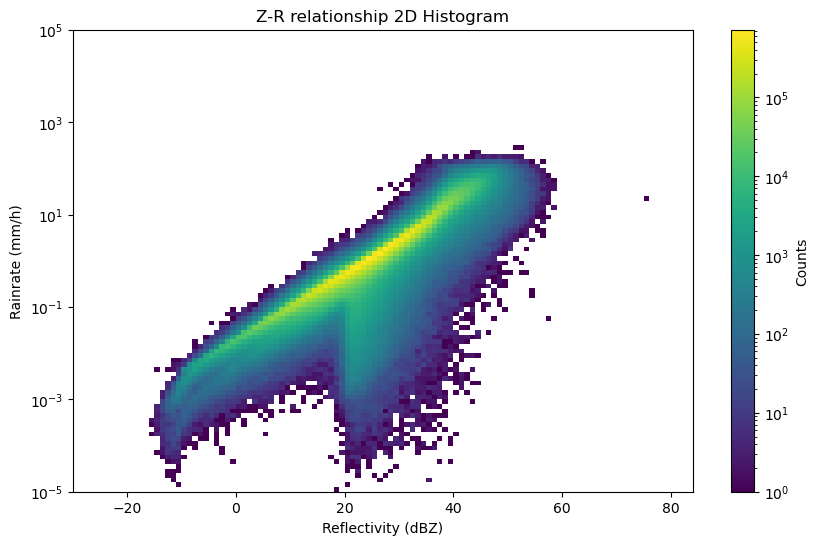

In [31]:
# Prepare data for 2D histogram
#dbz_flat = dbz2.values.flatten()
#rainrate_flat = rainrate2.values.flatten()
dbz_flat = dbz2[indexAP:-1,:,:].values.flatten()  # Use only data after AP time
rainrate_flat = rainrate2[indexAP:-1,:,:].values.flatten()  # Use only data after AP time

# Filter out NaN values
mask = ~np.isnan(dbz_flat)
dbz_flat_filtered = dbz_flat[mask]
rainrate_flat_filtered = rainrate_flat[mask]

# Calculate 2D histogram
#pbins = np.concatenate((np.arange(0,1e-4,1e-5),np.arange(1e-4,1e-3,1e-4),np.arange(1e-3,0.01,1e-3),np.arange(0.01,0.1,0.01),np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,100,10),np.arange(100,1000,100),np.arange(1000,10000,1000),np.arange(10000,100000,10000)))
pbins = np.concatenate(([0],np.power(10,np.arange(-5,5,0.1))))
dbzbins = np.arange(-30,85,1)
hist, xedges, yedges = np.histogram2d(dbz_flat_filtered, np.transpose(rainrate_flat_filtered), bins=[dbzbins, pbins],range=[[-30, 80], [0, 100000]])

# Plot 2D histogram
plt.figure(figsize=(10,6))
dbzmesh,pmesh = np.meshgrid(xedges, yedges)
plt.pcolormesh(dbzmesh, pmesh, hist.T, norm=LogNorm(), cmap='viridis', shading='auto')
#plt.imshow(hist.T, origin='lower', aspect='auto', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Counts')
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.yscale('log')
plt.ylim(1e-5,1e5)
plt.title('Z-R relationship 2D Histogram')
plt.show()

In [32]:
seapol.time[np.where(rain245 == np.nanmax(rain245))]

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2024-09-11T06:45:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-09-11T06:45:00
Attributes:
    standard_name:  time
    long_name:      Data time
    axis:           T
    comment:        
    cell_methods:   time: mean

# Troubleshooting bad data

In [33]:
time_check = np.datetime64('2024-09-22T15:50:00')

#Find indices for start and end times
itime = np.abs(pd.to_datetime(seapol.time) - time_check).argmin()

In [34]:
np.where(seapol.RAINRATE[itime,:,:] == np.nanmax(seapol.RAINRATE[itime,:,:].values))

(array([70]), array([327]))

In [35]:
seapol.DBZ[itime,69,331].values

array(-9999., dtype=float32)

In [36]:
seapol.DBZ[itime,70,332].values

array(-9999., dtype=float32)

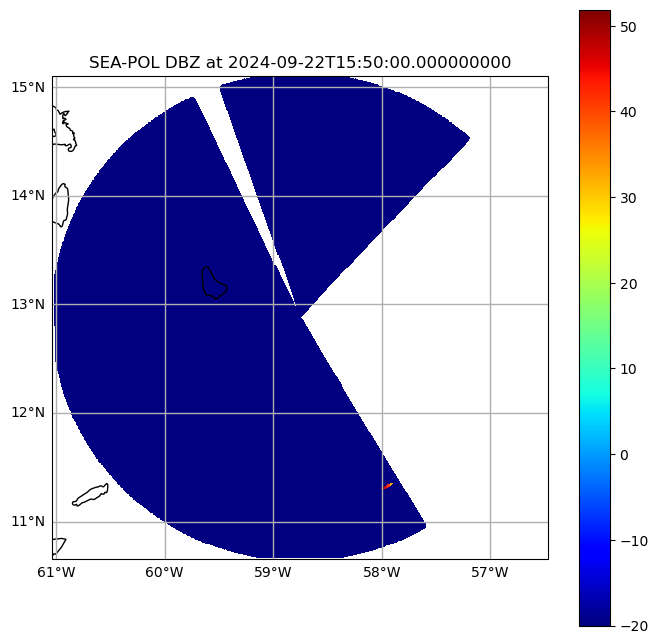

In [37]:
proj = {'projection': ccrs.PlateCarree()}
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=proj)
#plt.pcolormesh(seapol.longitude[itime,50:100,310:350], seapol.latitude[itime,50:100,310:350], seapol.RAINRATE[itime,50:100,310:350], cmap='jet', vmin=0)
plt.pcolormesh(seapol.longitude[itime,:,:], seapol.latitude[itime,:,:], seapol.DBZ[itime,:,:], cmap='jet', vmin=-20)
plt.colorbar()
plt.title('SEA-POL DBZ at ' + str(seapol.time[itime].values))
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1)
ax.coastlines()
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plot time series

/tmp/ipykernel_352484/1481853906.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_352484/1481853906.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -1.0, '−1'),
 Text(0, 0.0, '0'),
 Text(0, 1.0, '1'),
 Text(0, 2.0, '2'),
 Text(0, 3.0, '3'),
 Text(0, 4.0, '4'),
 Text(0, 5.0, '5'),
 Text(0, 6.0, '6'),
 Text(0, 7.0, '7')]

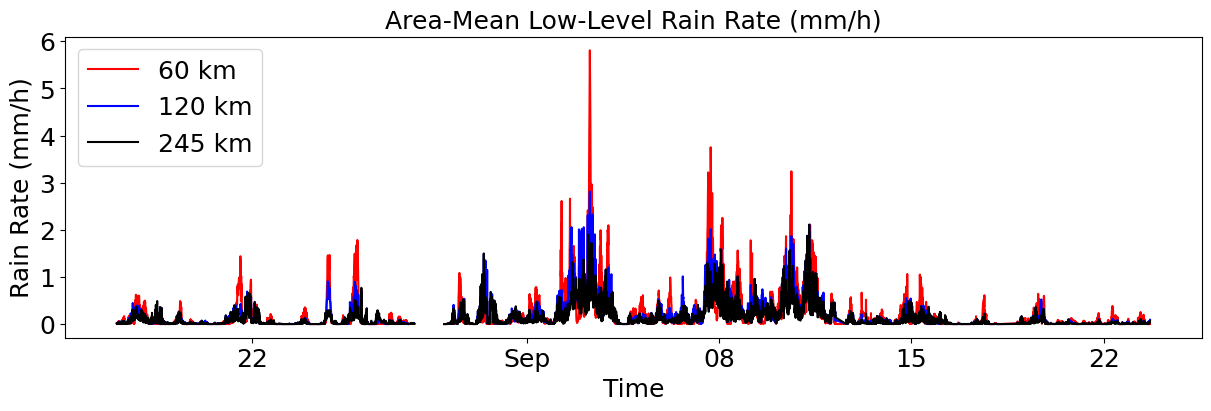

In [54]:
#Plot for whole campaign (all data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

#ax.plot(seapol.time, rain12, color='purple', label='12 km')
ax.plot(seapol.time, rain60, color='red', label='60 km')
ax.plot(seapol.time, rain120, color='blue', label='120 km')
ax.plot(seapol.time, rain245, color='black', label='245 km')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

#ax.set_ylim(0, 4)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_352484/648408658.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_352484/648408658.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -10.0, '−10'),
 Text(0, 0.0, '0'),
 Text(0, 10.0, '10'),
 Text(0, 20.0, '20'),
 Text(0, 30.0, '30'),
 Text(0, 40.0, '40'),
 Text(0, 50.0, '50'),
 Text(0, 60.0, '60')]

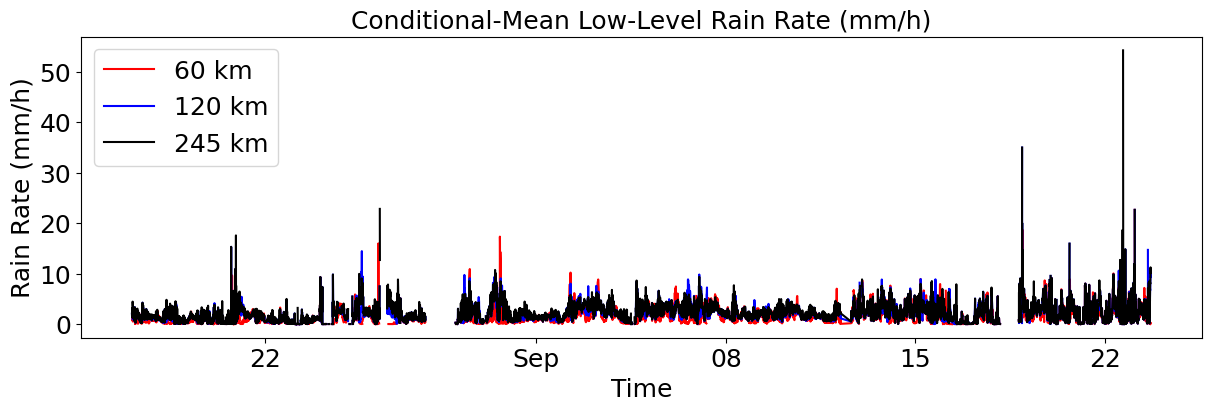

In [55]:
#Plot rain intensity (all data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

#ax.plot(seapol.time, rain12cond, color='purple', label='12 km')
ax.plot(seapol.time, rain60cond, color='red', label='60 km')
ax.plot(seapol.time, rain120cond, color='blue', label='120 km')
ax.plot(seapol.time, rain245cond, color='black', label='245 km')
ax.set_title('Conditional-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_352484/229402442.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_352484/229402442.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -1.0, '−1'),
 Text(0, 0.0, '0'),
 Text(0, 1.0, '1'),
 Text(0, 2.0, '2'),
 Text(0, 3.0, '3'),
 Text(0, 4.0, '4'),
 Text(0, 5.0, '5'),
 Text(0, 6.0, '6'),
 Text(0, 7.0, '7')]

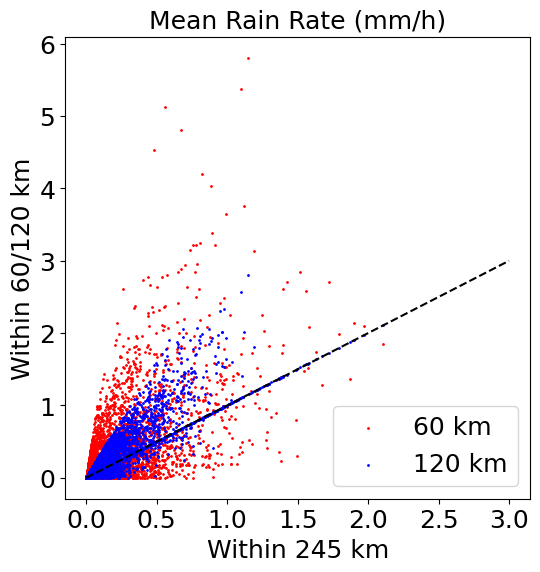

In [58]:
# make a scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(rain245, rain60,s=1,color='red',label='60 km')
ax.scatter(rain245, rain120,s=1,color='blue',label='120 km')

#Plot 1:1 line
x = np.linspace(0, 3, 100)
ax.plot(x, x, color='black', linestyle='--')

# legend
ax.legend(loc='lower right', fontsize=18)

ax.set_xlabel('Within 245 km', fontsize=18)
ax.set_ylabel('Within 60/120 km', fontsize=18)
ax.set_title('Mean Rain Rate (mm/h)', fontsize=18)

#ax.set_xlim(0,3)
#ax.set_ylim(0,3)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


/tmp/ipykernel_352484/2535495963.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_352484/2535495963.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -10.0, '−10'),
 Text(0, 0.0, '0'),
 Text(0, 10.0, '10'),
 Text(0, 20.0, '20'),
 Text(0, 30.0, '30'),
 Text(0, 40.0, '40'),
 Text(0, 50.0, '50'),
 Text(0, 60.0, '60'),
 Text(0, 70.0, '70'),
 Text(0, 80.0, '80')]

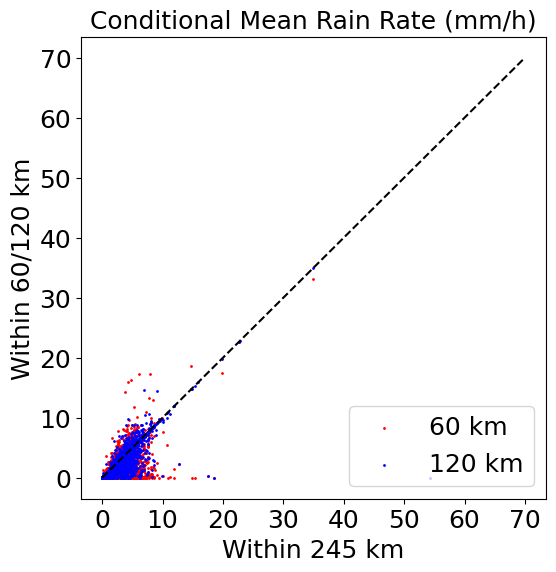

In [59]:
# make a scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(rain245cond, rain60cond,s=1,color='red',label='60 km')
ax.scatter(rain245cond, rain120cond,s=1,color='blue',label='120 km')

#Plot 1:1 line
x = np.linspace(0, 70, 100)
ax.plot(x, x, color='black', linestyle='--')

# legend
ax.legend(loc='lower right', fontsize=18)

ax.set_xlabel('Within 245 km', fontsize=18)
ax.set_ylabel('Within 60/120 km', fontsize=18)

ax.set_title('Conditional Mean Rain Rate (mm/h)', fontsize=18)

#ax.set_xlim(0,30)
#ax.set_ylim(0,30)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# More data troublshooting

In [42]:
# Search times
time1 = np.datetime64('2024-09-21T18:00:00')
time2 = np.datetime64('2024-09-21T18:30:00')

#Find indices for start and end times
index1 = np.abs(pd.to_datetime(seapol.time) - time1).argmin()
index2 = np.abs(pd.to_datetime(seapol.time) - time2).argmin()

/tmp/ipykernel_352484/618504414.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_352484/618504414.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -0.1, '−0.1'),
 Text(0, 0.0, '0.0'),
 Text(0, 0.1, '0.1'),
 Text(0, 0.20000000000000004, '0.2'),
 Text(0, 0.30000000000000004, '0.3'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.5000000000000001, '0.5'),
 Text(0, 0.6000000000000001, '0.6'),
 Text(0, 0.7000000000000001, '0.7'),
 Text(0, 0.8, '0.8')]

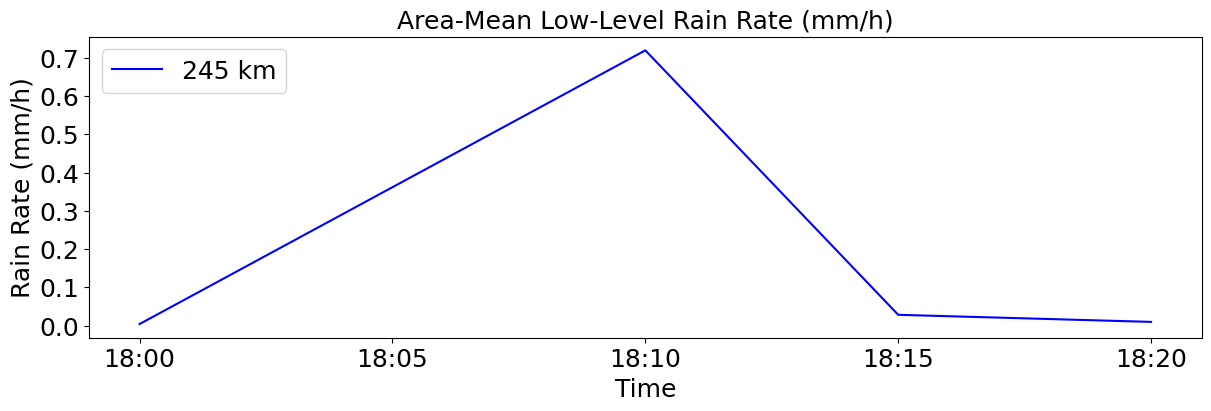

In [43]:
#Plot time series

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")
ax.plot(seapol.time[index1:index2], rain245[index1:index2], color='blue', label='245 km')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

In [44]:
seapol.time[index1:index2]

<xarray.DataArray 'time' (time: 4)> Size: 32B
array(['2024-09-21T18:00:00.000000000', '2024-09-21T18:10:00.000000000',
       '2024-09-21T18:15:00.000000000', '2024-09-21T18:20:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 32B 2024-09-21T18:00:00 ... 2024-09-21T18:...
Attributes:
    standard_name:  time
    long_name:      Data time
    axis:           T
    comment:        
    cell_methods:   time: mean

In [45]:
index1

np.int64(7822)

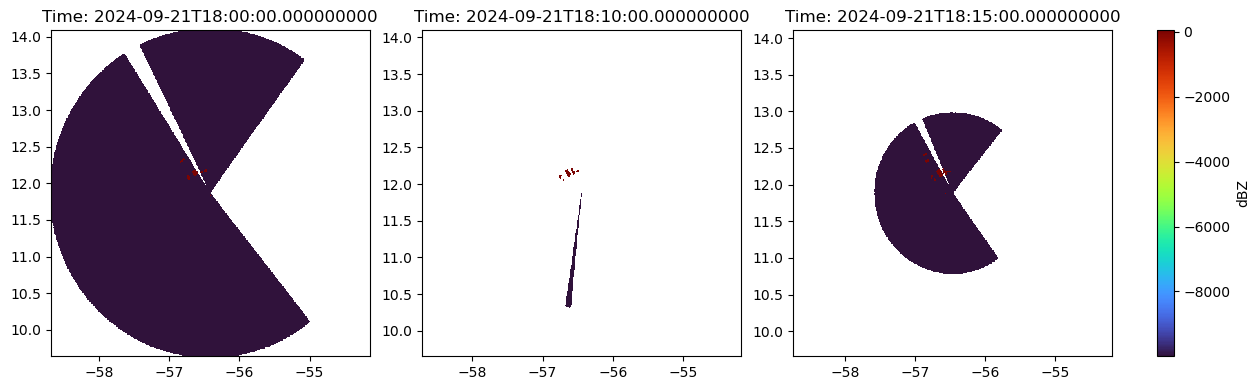

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

#axes[0,0].pcolormesh(seapol.longitude[4173,250:310,180:260], seapol.latitude[4173,250:310,180:260], rainrate4[4173,250:310,180:260], cmap='turbo')
#axes[0,1].pcolormesh(seapol.longitude[4174,250:310,180:260], seapol.latitude[4174,250:310,180:260], rainrate4[4174,250:310,180:260], cmap='turbo')
axes[0].pcolormesh(seapol.longitude[index1,:,:], seapol.latitude[index1,:,:], seapol.DBZ[index1,:,:], cmap='turbo')
axes[1].pcolormesh(seapol.longitude[index1+1,:,:], seapol.latitude[index1+1,:,:], seapol.DBZ[index1+1,:,:], cmap='turbo')
axes[2].pcolormesh(seapol.longitude[index1+2,:,:], seapol.latitude[index1+2,:,:], seapol.DBZ[index1+2,:,:], cmap='turbo')

axes[0].set_title(f'Time: {seapol.time[index1].values}', fontsize=12)
axes[1].set_title(f'Time: {seapol.time[index1+1].values}', fontsize=12) 
axes[2].set_title(f'Time: {seapol.time[index1+2].values}', fontsize=12)

fig.tight_layout()
cbar = fig.colorbar(axes[0].collections[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('dBZ')

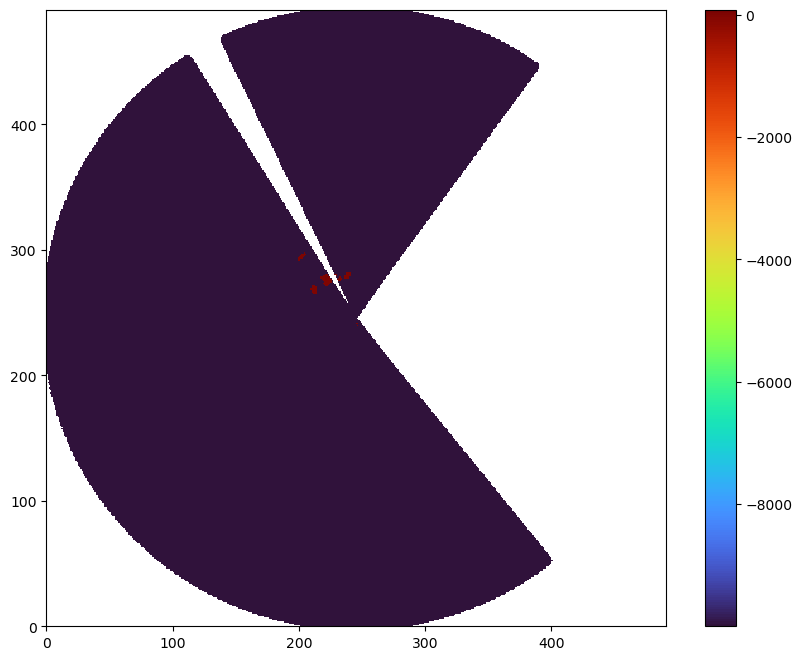

In [60]:
fig,axes = plt.subplots(figsize=(10,8))

#cmap_dbz = mcolors.ListedColormap(['white'] + list(plt.cm.get_cmap('radar.reflectivity')(np.linspace(0, 1, 256))))
#cmap_dbz.set_bad('silver')
#bounds = [-9999, -100, 60]

plt.pcolormesh(seapol.RAINRATE[index1,:,:], cmap='turbo')
plt.colorbar()

In [61]:
seapol.RAINRATE[index1,350,100].values 

array(-9999., dtype=float32)

In [62]:
seapol.RAINRATE[index2,350,100].values

array(nan, dtype=float32)

# Extracting time series at specific times

In [74]:
rain = xr.open_dataset('../../data/SEA-POL_4v1.0_rainrate_2D_spatial_means_masked.nc')
rain

<xarray.Dataset> Size: 399kB
Dimensions:       (time: 8312)
Coordinates:
  * time          (time) datetime64[ns] 66kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables:
    rain245_mean  (time) float32 33kB ...
    rain120_mean  (time) float32 33kB ...
    rain60_mean   (time) float32 33kB ...
    rain12_mean   (time) float32 33kB ...
    rain1_mean    (time) float32 33kB ...
    rain245_int   (time) float32 33kB ...
    rain120_int   (time) float32 33kB ...
    rain60_int    (time) float32 33kB ...
    rain12_int    (time) float32 33kB ...
    rain1_int     (time) float32 33kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4b Gridded 2D Rain Rate
    units:        mm/h

In [75]:
# Search times
time1 = np.datetime64('2024-09-22T16:00:00')
time2 = np.datetime64('2024-09-23T16:00:00')

time3 = np.datetime64('2024-09-23T00:40:00')
time4 = np.datetime64('2024-09-23T07:00:00')
time5 = np.datetime64('2024-09-23T09:10:00')

#Find indices for start and end times
index1 = np.abs(pd.to_datetime(rain.time) - time1).argmin()
index2 = np.abs(pd.to_datetime(rain.time) - time2).argmin()
index3 = np.abs(pd.to_datetime(rain.time) - time3).argmin()
index4 = np.abs(pd.to_datetime(rain.time) - time4).argmin()
index5 = np.abs(pd.to_datetime(rain.time) - time5).argmin()

/tmp/ipykernel_352484/1411512925.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_352484/1411512925.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_352484/1411512925.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)


[Text(1, -0.5, '−0.5'),
 Text(1, 0.0, '0.0'),
 Text(1, 0.5, '0.5'),
 Text(1, 1.0, '1.0'),
 Text(1, 1.5, '1.5'),
 Text(1, 2.0, '2.0'),
 Text(1, 2.5, '2.5'),
 Text(1, 3.0, '3.0'),
 Text(1, 3.5, '3.5'),
 Text(1, 4.0, '4.0')]

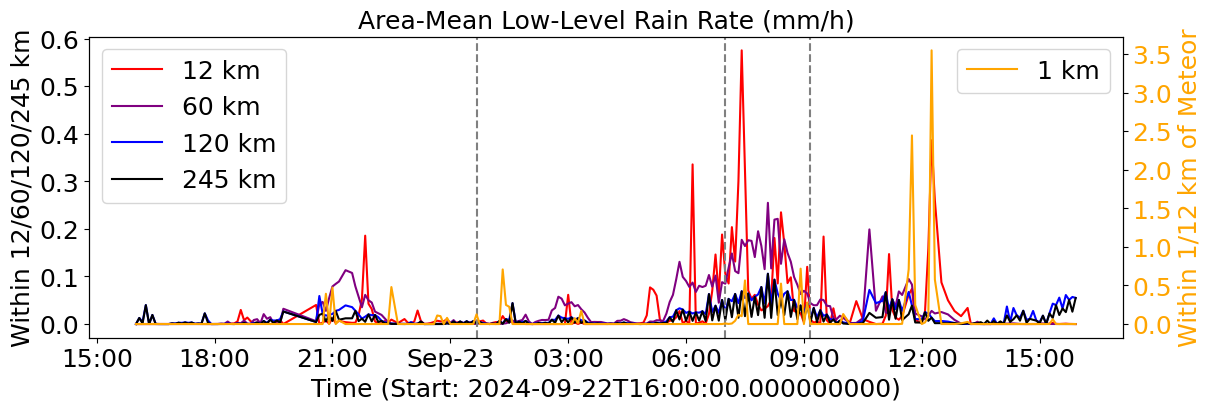

In [76]:
# make plot
fig,ax = plt.subplots(figsize=(12,4),layout="constrained")
ax.plot(rain.time[index1:index2], rain.rain12_mean[index1:index2].values, color='red', label='12 km')
ax.plot(rain.time[index1:index2], rain.rain60_mean[index1:index2].values, color='purple', label='60 km')
ax.plot(rain.time[index1:index2], rain.rain120_mean[index1:index2].values, color='blue', label='120 km')
ax.plot(rain.time[index1:index2], rain.rain245_mean[index1:index2].values, color='black', label='245 km')

#plot vertical line at time index3
ax.axvline(x=rain.time[index3].values, color='gray', linestyle='--')
ax.axvline(x=rain.time[index4].values, color='gray', linestyle='--')
ax.axvline(x=rain.time[index5].values, color='gray', linestyle='--')

ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Within 12/60/120/245 km', fontsize=18)
ax.set_xlabel(f"Time (Start: {rain.time[index1].values})",fontsize=18)
#ax.set_ylim(0, 4)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax2 = ax.twinx()
ax2.plot(rain.time[index1:index2], rain.rain1_mean[index1:index2].values, color='orange', label='1 km')
#ax2.plot(rain.time[index1:index2], rain.rain12_mean[index1:index2].values, color='red', label='12 km')
#ax2.set_ylim(0,15)
ax2.set_ylabel('Within 1/12 km of Meteor',color='orange',fontsize=18)

ax2.legend(loc='upper right', fontsize=18)
ax2.tick_params(axis='y',labelcolor='orange')
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)

In [77]:
# Search times
timesearch = np.datetime64('2024-09-23T00:40:00')

#Find indices for start and end times
index = np.abs(pd.to_datetime(rain.time) - timesearch).argmin()
index

np.int64(8139)

In [78]:
indexX = np.abs(seapol.X - -12000).argmin()
indexX = np.abs(seapol.X - 12000).argmin()
indexX

<xarray.DataArray 'X' ()> Size: 8B
array(257)

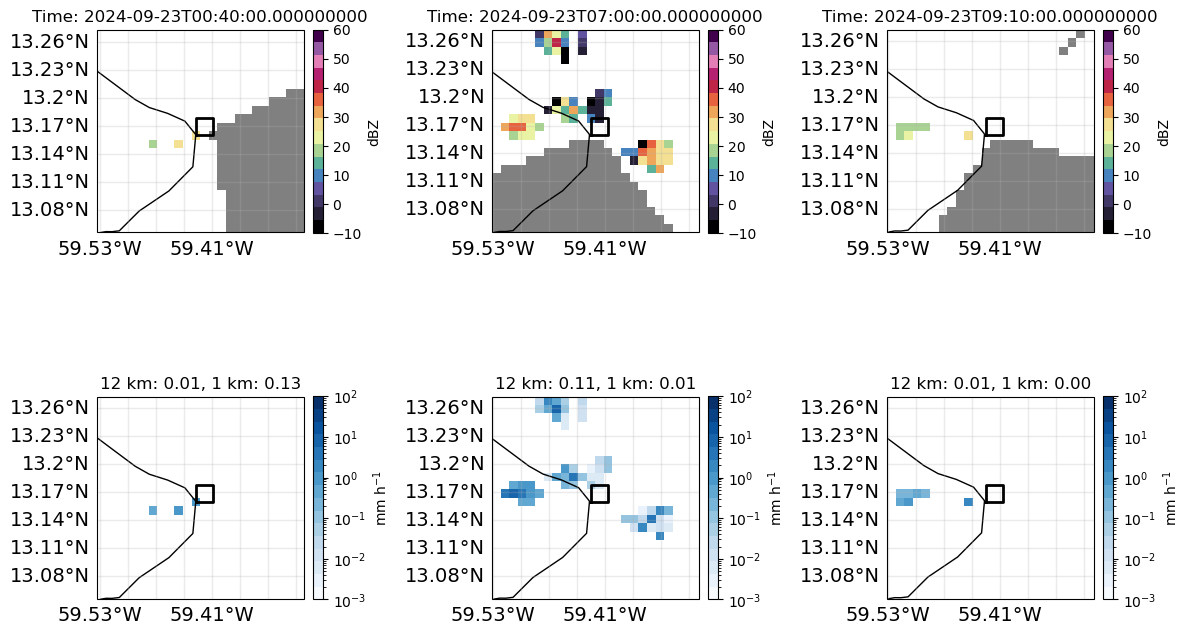

In [79]:
#proj = ccrs.TransverseMercator(central_longitude=seapol.longitude[4390,245,245].values, central_latitude=seapol.latitude[4390,245,245].values)
proj = ccrs.PlateCarree()   

fig, axes = plt.subplots(2, 3, figsize=(12,8),subplot_kw={'projection': proj})

rain_cmap=plt.get_cmap('Blues').copy()
rain_cmap = ListedColormap(rain_cmap(np.linspace(0, 1, 16)))
rain_cmap.set_under(color='white') #set values below vmin to white
rain_cmap.set_over(color='red') #set values above vmax to blue

gl = axes[0,0].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

gl = axes[0,1].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

gl = axes[0,2].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

gl = axes[1,0].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

gl = axes[1,1].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

gl = axes[1,2].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

axes[1,0].pcolormesh(seapol.longitude[index3,233:257,233:257], seapol.latitude[index3,233:257,233:257], rainrate4[index3,233:257,233:257], cmap=rain_cmap, norm=colors.LogNorm(vmin=0.001,vmax=100))
axes[1,1].pcolormesh(seapol.longitude[index4,233:257,233:257], seapol.latitude[index4,233:257,233:257], rainrate4[index4,233:257,233:257], cmap=rain_cmap, norm=colors.LogNorm(vmin=0.001,vmax=100))
axes[1,2].pcolormesh(seapol.longitude[index5,233:257,233:257], seapol.latitude[index5,233:257,233:257], rainrate4[index5,233:257,233:257], cmap=rain_cmap, norm=colors.LogNorm(vmin=0.001,vmax=100))

axes[0,0].pcolormesh(seapol.longitude[index3,233:257,233:257], seapol.latitude[index3,233:257,233:257], dbz[index3,233:257,233:257], cmap=discrete_mask_cmap, vmin=-10, vmax=60)
axes[0,1].pcolormesh(seapol.longitude[index4,233:257,233:257], seapol.latitude[index4,233:257,233:257], dbz[index4,233:257,233:257], cmap=discrete_mask_cmap, vmin=-10, vmax=60)
axes[0,2].pcolormesh(seapol.longitude[index5,233:257,233:257], seapol.latitude[index5,233:257,233:257], dbz[index5,233:257,233:257], cmap=discrete_mask_cmap, vmin=-10, vmax=60)

fig.tight_layout()

#draw a 1 km box
x_start = seapol.longitude[index3,245,244].values
x_end = seapol.longitude[index3,245,246].values
y_start = seapol.latitude[index3,244,245].values
y_end = seapol.latitude[index3,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[0,0].plot(*box_coord, color='black', linewidth=2)

x_start = seapol.longitude[index4,245,244].values
x_end = seapol.longitude[index4,245,246].values
y_start = seapol.latitude[index4,244,245].values
y_end = seapol.latitude[index4,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[0,1].plot(*box_coord, color='black', linewidth=2)

x_start = seapol.longitude[index5,245,244].values
x_end = seapol.longitude[index5,245,246].values
y_start = seapol.latitude[index5,244,245].values
y_end = seapol.latitude[index5,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[0,2].plot(*box_coord, color='black', linewidth=2)

x_start = seapol.longitude[index3,245,244].values
x_end = seapol.longitude[index3,245,246].values
y_start = seapol.latitude[index3,244,245].values
y_end = seapol.latitude[index3,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[1,0].plot(*box_coord, color='black', linewidth=2)

x_start = seapol.longitude[index4,245,244].values
x_end = seapol.longitude[index4,245,246].values
y_start = seapol.latitude[index4,244,245].values
y_end = seapol.latitude[index4,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[1,1].plot(*box_coord, color='black', linewidth=2)

x_start = seapol.longitude[index5,245,244].values
x_end = seapol.longitude[index5,245,246].values
y_start = seapol.latitude[index5,244,245].values
y_end = seapol.latitude[index5,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[1,2].plot(*box_coord, color='black', linewidth=2)

axes[0,0].set_title(f'Time: {rain.time[index3].values}', fontsize=12)
axes[0,1].set_title(f'Time: {rain.time[index4].values}', fontsize=12) 
axes[0,2].set_title(f'Time: {rain.time[index5].values}', fontsize=12)

axes[1,0].set_title(f'12 km: {rain.rain12_mean[index3].values:.2f}, 1 km: {rain.rain1_mean[index3].values:.2f}', fontsize=12)
axes[1,1].set_title(f'12 km: {rain.rain12_mean[index4].values:.2f}, 1 km: {rain.rain1_mean[index4].values:.2f}', fontsize=12)
axes[1,2].set_title(f'12 km: {rain.rain12_mean[index5].values:.2f}, 1 km: {rain.rain1_mean[index5].values:.2f}', fontsize=12)

cbar = fig.colorbar(axes[0,0].collections[0], ax=axes[0,0], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('dBZ')

cbar = fig.colorbar(axes[0,1].collections[0], ax=axes[0,1], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('dBZ')

cbar = fig.colorbar(axes[0,2].collections[0], ax=axes[0,2], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('dBZ')

cbar = fig.colorbar(axes[1,0].collections[0], ax=axes[1,0], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('mm h$^{-1}$')

cbar = fig.colorbar(axes[1,1].collections[0], ax=axes[1,1], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('mm h$^{-1}$')

cbar = fig.colorbar(axes[1,2].collections[0], ax=axes[1,2], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('mm h$^{-1}$')

axes[0,0].coastlines()
axes[0,1].coastlines()
axes[0,2].coastlines()
axes[1,0].coastlines()
axes[1,1].coastlines()
axes[1,2].coastlines()

fig.tight_layout()

Some pixels have re-emerged compared to 4b

# Time series for specific time period

In [80]:
# Search times
time1 = np.datetime64('2024-09-08T08:00:00')
time2 = np.datetime64('2024-09-08T14:00:00')

#Find indices for start and end times
index1 = np.abs(pd.to_datetime(rain.time) - time1).argmin()
index2 = np.abs(pd.to_datetime(rain.time) - time2).argmin()

Add disdrometer data

In [81]:
disdro = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Distrometer/QC/final/DSD_METEOR_merged.nc')

#Find indices for start and end times
index_start_disdro = np.where(pd.to_datetime(disdro.time) == time1)[0]
index_start_disdro = int(index_start_disdro[0])

index_end_disdro = np.where(pd.to_datetime(disdro.time) == time2)[0]
index_end_disdro = int(index_end_disdro[0])

# Smooth with a running mean, restrict to the time period of interest
disdro_p = disdro.rain_rate_qc[index_start_disdro:index_end_disdro+1].rolling(time=10, center=True).mean() # 10 minute running mean
disdro

<xarray.Dataset> Size: 255MB
Dimensions:                       (time: 56160, particle_size: 32,
                                   raw_fall_velocity: 32)
Coordinates:
  * time                          (time) datetime64[ns] 449kB 2024-08-16 ... ...
  * particle_size                 (particle_size) float32 128B 0.062 ... 24.5
  * raw_fall_velocity             (raw_fall_velocity) float32 128B 0.05 ... 20.8
Data variables: (12/45)
    missing_data_flag             (time) int32 225kB ...
    lon                           (time) float32 225kB ...
    lat                           (time) float32 225kB ...
    hgt                           (time) float32 225kB ...
    qc_number_detected_particles  (time) float32 225kB ...
    qc_spectrum                   (time, raw_fall_velocity, particle_size) float32 230MB ...
    ...                            ...
    delta_co_x                    (time) float32 225kB ...
    kdp_x                         (time) float32 225kB ...
    ai_x                          (time) float32 225kB ...
    adr_x                         (time) float32 225kB ...
    conv_strat                    (time) float32 225kB ...
    greatest_RR_flag              (time) float64 449kB ...
Attributes: (12/23)
    title:                           Merged PARSIVEL Disdrometer QCed data
    summary:                         The merged version contains data from th...
    creator_name:                    Delián Colón-Burgos
    creator_email:                   delianb@colostate.edu
    project:                         ['ORCESTRA', 'BOW-TIE', 'PICCOLO']
    platform:                        RV METEOR
    ...                              ...
    tmatrix_canting_mean_angle:      0.0 degrees
    tmatrix_canting_std:             7.5 degrees
    tmatrix_drop_model:              Thurai and Bringi (2005)
    simulated_s_freq:                2997924580 Hz
    simulated_c_freq:                5995849160 Hz
    simulated_x_freq:                9993081933 Hz

/tmp/ipykernel_352484/3689614071.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_352484/3689614071.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_352484/3689614071.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)


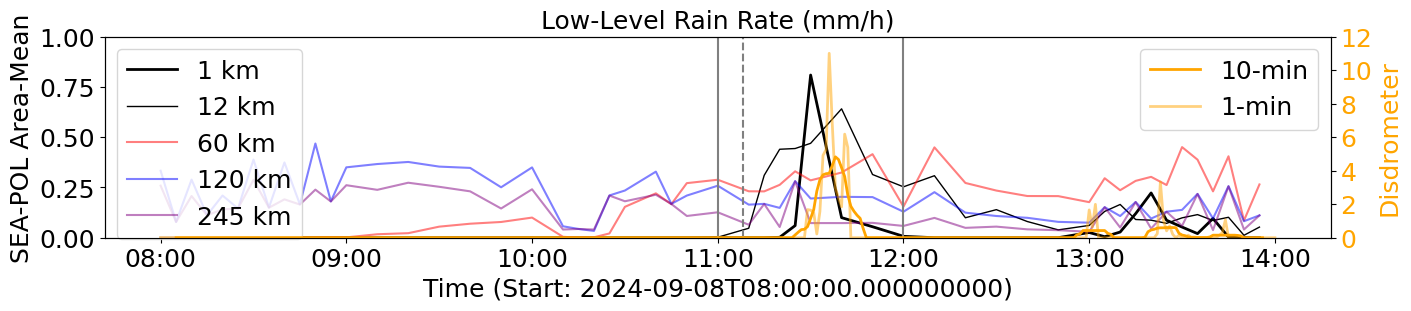

In [82]:
# make plot
fig,ax = plt.subplots(figsize=(14,3),layout="constrained")
ax.plot(rain.time[index1:index2], rain.rain1_mean[index1:index2].values, color='black', label='1 km',linewidth=2)
ax.plot(rain.time[index1:index2], rain.rain12_mean[index1:index2].values, color='black', label='12 km',linewidth=1)
ax.plot(rain.time[index1:index2], rain.rain60_mean[index1:index2].values, color='red', alpha=0.5, label='60 km')
ax.plot(rain.time[index1:index2], rain.rain120_mean[index1:index2].values, color='blue', alpha=0.5, label='120 km')
ax.plot(rain.time[index1:index2], rain.rain245_mean[index1:index2].values, color='purple', alpha=0.5, label='245 km')

#vertical lines at specific times
ax.axvline(x=pd.to_datetime('2024-09-08T11:00:00'), color='gray', linestyle='-')
ax.axvline(x=pd.to_datetime('2024-09-08T11:08:00'), color='gray', linestyle='--')
ax.axvline(x=pd.to_datetime('2024-09-08T12:00:00'), color='gray', linestyle='-')

ax.set_title('Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('SEA-POL Area-Mean', fontsize=18)
ax.set_xlabel(f"Time (Start: {rain.time[index1].values})",fontsize=18)
ax.set_ylim(0, 2)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax2 = ax.twinx()
ax2.plot(disdro.time[index_start_disdro:index_end_disdro+1], disdro_p.values, color='orange', linewidth=2,label='10-min')
ax2.plot(disdro.time[index_start_disdro:index_end_disdro+1], disdro.rain_rate_qc[index_start_disdro:index_end_disdro+1].values, color='orange', alpha=0.5, linewidth=2,label='1-min')
ax2.set_ylim(0,12)
ax2.set_ylabel('Disdrometer',color='orange',fontsize=18)
ax2.tick_params(axis='y',labelcolor='orange')
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)
ax2.legend(loc='upper right', fontsize=18)
